In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    classification_report, confusion_matrix
)
from imblearn.over_sampling import RandomOverSampler
import warnings
warnings.filterwarnings('ignore')

nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('punkt', quiet=True)

True

In [ ]:
TRAIN_PATH = './train.csv/train.csv'
df = pd.read_csv(TRAIN_PATH)
print(f"Original dataset shape: {df.shape}")

Original dataset shape: (159571, 8)


In [ ]:
toxicity_labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [ ]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    if pd.isna(text):
        return ""
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'<.*?>', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\d+', '', text)
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(t) for t in tokens if t not in stop_words]
    return ' '.join(tokens)

df['clean_comment'] = df['comment_text'].apply(preprocess_text)
df = df[df['clean_comment'].str.len() > 0].copy()
print(f"After preprocessing: {df.shape[0]} comments remaining")

After preprocessing: 159505 comments remaining


In [ ]:
vectorizer = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.95,
    sublinear_tf=True
)
X = vectorizer.fit_transform(df['clean_comment'])
y = df[toxicity_labels].values

print(f"Feature matrix shape: {X.shape}")

Feature matrix shape: (159505, 10000)


In [ ]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Training set shape: (127604, 10000)
Test set shape: (31901, 10000)


In [ ]:
# Prepare models, thresholds, and results containers
models = {}
thresholds = {}
results = {}

In [ ]:
# Train Naive Bayes per label with oversampling + class weights + threshold tuning
for i, label in enumerate(toxicity_labels):
    print(f"\nTraining model for '{label}'...")

    ros = RandomOverSampler(random_state=42)
    X_resampled, y_resampled = ros.fit_resample(X_train, y_train[:, i])

    clf = MultinomialNB()
    clf.fit(X_resampled, y_resampled)
    models[label] = clf

    y_prob = clf.predict_proba(X_test)[:, 1]

    best_thresh = 0.5
    best_f1 = 0
    for t in np.arange(0.1, 0.9, 0.01):
        y_pred_t = (y_prob >= t).astype(int)
        f1 = f1_score(y_test[:, i], y_pred_t, zero_division=0)
        if f1 > best_f1:
            best_f1 = f1
            best_thresh = t

    thresholds[label] = best_thresh
    y_pred = (y_prob >= best_thresh).astype(int)

    results[label] = {
        'accuracy': accuracy_score(y_test[:, i], y_pred),
        'precision': precision_score(y_test[:, i], y_pred, zero_division=0),
        'recall': recall_score(y_test[:, i], y_pred, zero_division=0),
        'f1_score': best_f1,
        'roc_auc': roc_auc_score(y_test[:, i], y_prob)
    }

    print(f"{label.upper()} threshold: {best_thresh:.2f}")
    print(f"Accuracy:  {results[label]['accuracy']:.4f}")
    print(f"Precision: {results[label]['precision']:.4f}")
    print(f"Recall:    {results[label]['recall']:.4f}")
    print(f"F1-Score:  {results[label]['f1_score']:.4f}")
    print(f"ROC-AUC:   {results[label]['roc_auc']:.4f}")


Training model for 'toxic'...
TOXIC threshold: 0.80
Accuracy:  0.9492
Precision: 0.7443
Recall:    0.6996
F1-Score:  0.7213
ROC-AUC:   0.9505

Training model for 'severe_toxic'...
SEVERE_TOXIC threshold: 0.89
Accuracy:  0.9743
Precision: 0.2266
Recall:    0.7639
F1-Score:  0.3495
ROC-AUC:   0.9730

Training model for 'obscene'...
OBSCENE threshold: 0.89
Accuracy:  0.9692
Precision: 0.7272
Recall:    0.6669
F1-Score:  0.6957
ROC-AUC:   0.9559

Training model for 'threat'...
THREAT threshold: 0.89
Accuracy:  0.9803
Precision: 0.0814
Recall:    0.6463
F1-Score:  0.1446
ROC-AUC:   0.9544

Training model for 'insult'...
INSULT threshold: 0.89
Accuracy:  0.9626
Precision: 0.6158
Recall:    0.6162
F1-Score:  0.6160
ROC-AUC:   0.9534

Training model for 'identity_hate'...
IDENTITY_HATE threshold: 0.89
Accuracy:  0.9708
Precision: 0.1591
Recall:    0.5784
F1-Score:  0.2496
ROC-AUC:   0.9373


In [ ]:
y_pred_all = np.zeros_like(y_test)
for i, label in enumerate(toxicity_labels):
    prob = models[label].predict_proba(X_test)[:, 1]
    y_pred_all[:, i] = (prob >= thresholds[label]).astype(int)

In [ ]:
for i, label in enumerate(toxicity_labels):
    print(f"\nClassification report for '{label}':")
    print(classification_report(y_test[:, i], y_pred_all[:, i]))


Classification report for 'toxic':
              precision    recall  f1-score   support

           0       0.97      0.98      0.97     28905
           1       0.74      0.70      0.72      2996

    accuracy                           0.95     31901
   macro avg       0.86      0.84      0.85     31901
weighted avg       0.95      0.95      0.95     31901


Classification report for 'severe_toxic':
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     31613
           1       0.23      0.76      0.35       288

    accuracy                           0.97     31901
   macro avg       0.61      0.87      0.67     31901
weighted avg       0.99      0.97      0.98     31901


Classification report for 'obscene':
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     30214
           1       0.73      0.67      0.70      1687

    accuracy                           0.97     31901
   macro av

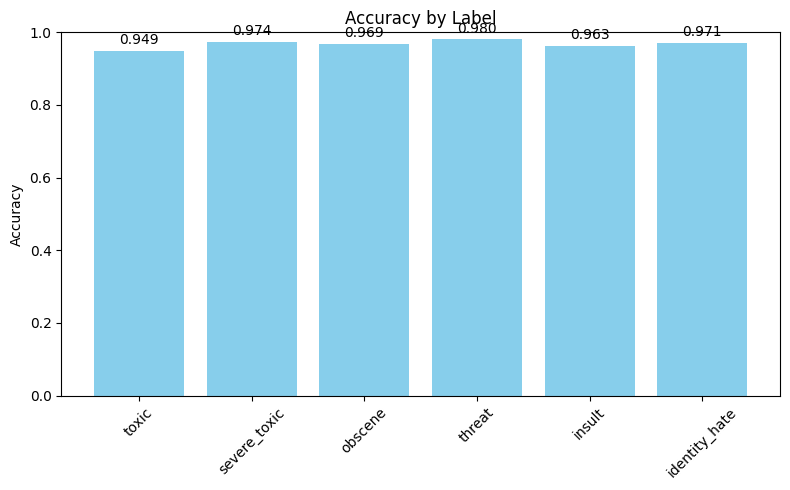

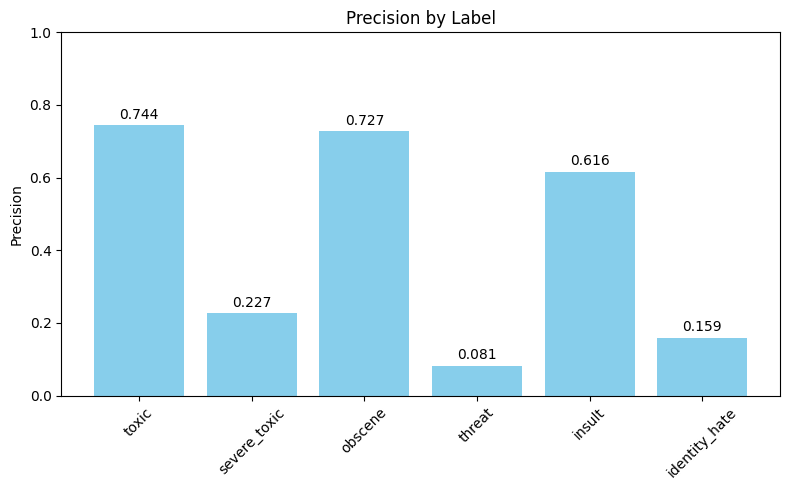

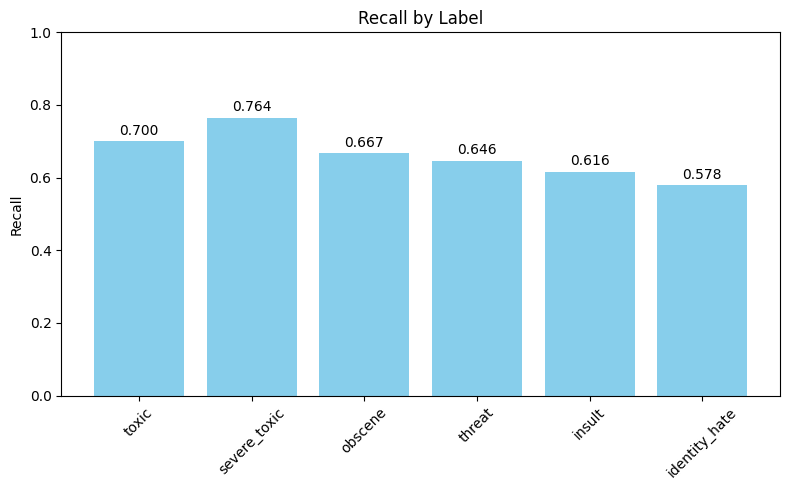

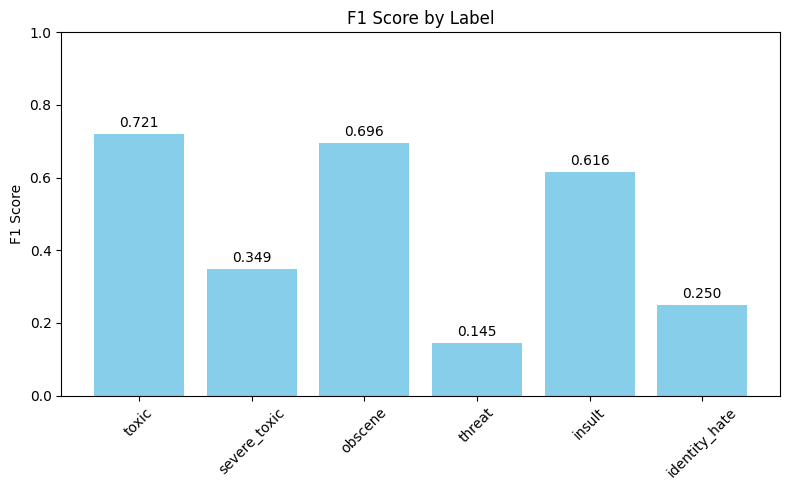

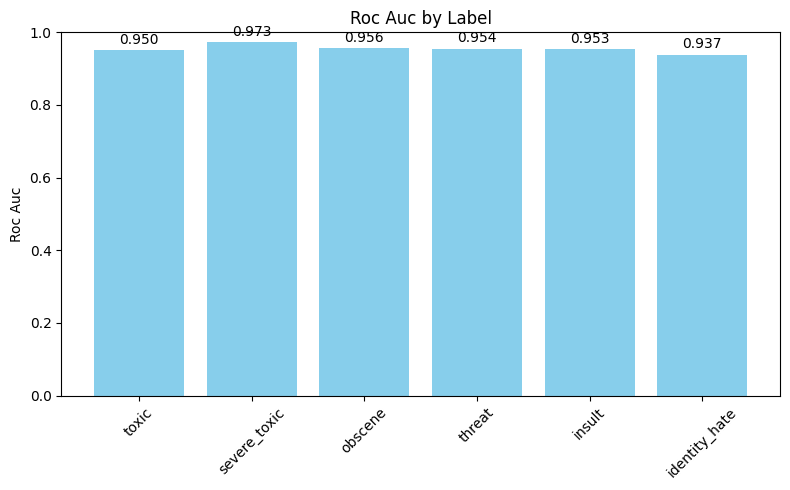

In [ ]:
metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']

for metric in metrics:
    values = [results[label][metric] for label in toxicity_labels]

    plt.figure(figsize=(8, 5))
    plt.bar(toxicity_labels, values, color='skyblue')
    plt.title(f'{metric.replace("_", " ").title()} by Label')
    plt.ylabel(metric.replace("_", " ").title())
    plt.ylim(0, 1)
    plt.xticks(rotation=45)

    for j, v in enumerate(values):
        plt.text(j, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

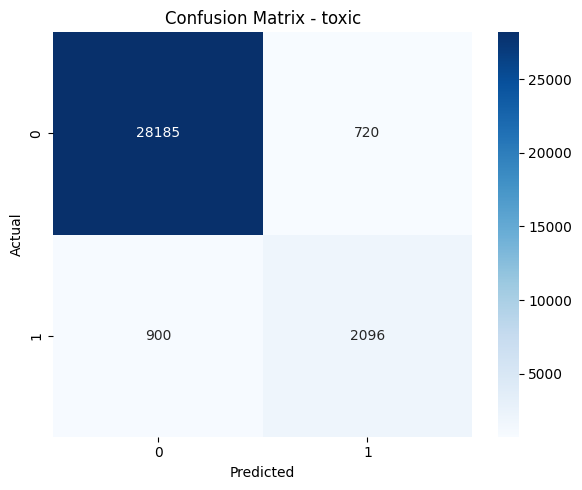

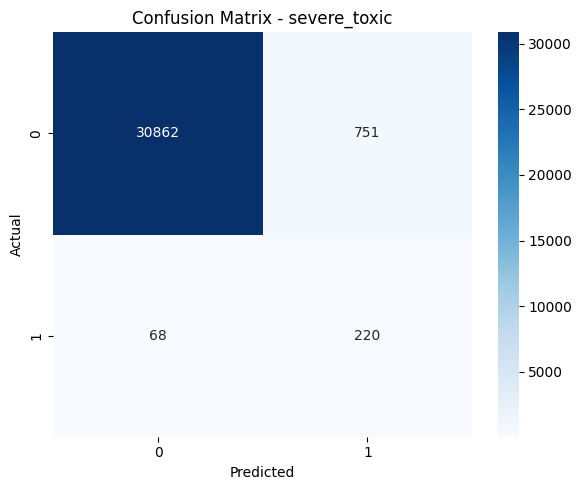

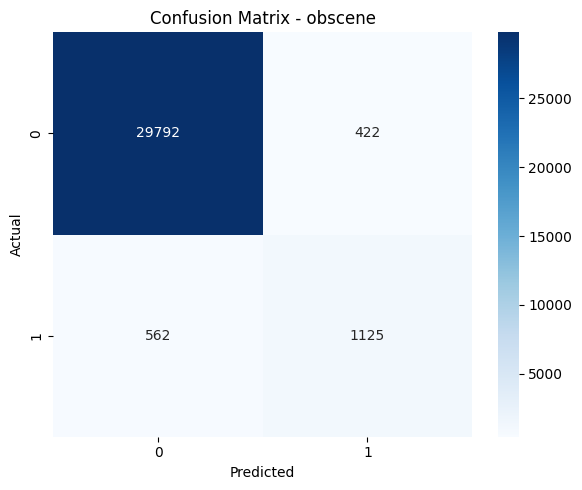

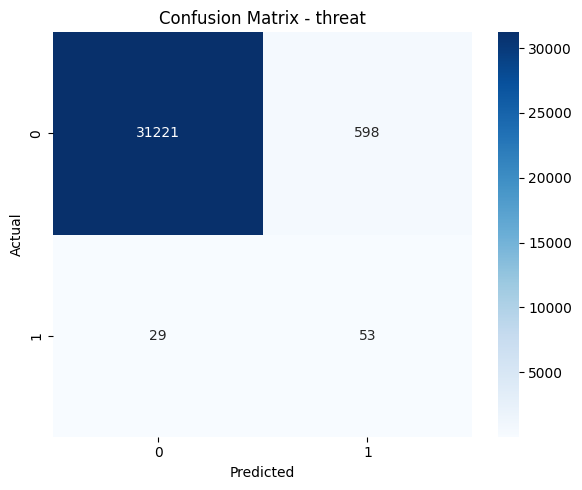

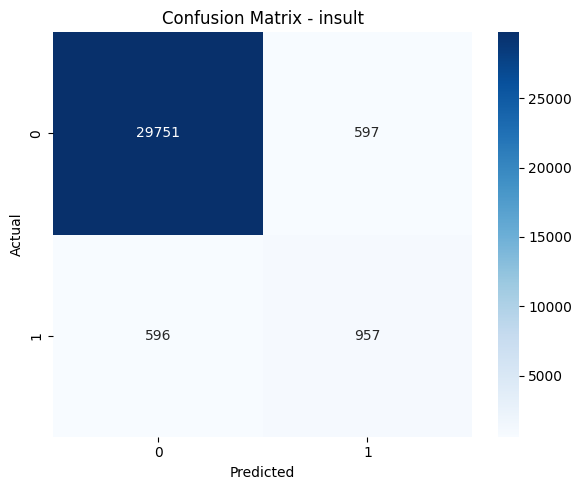

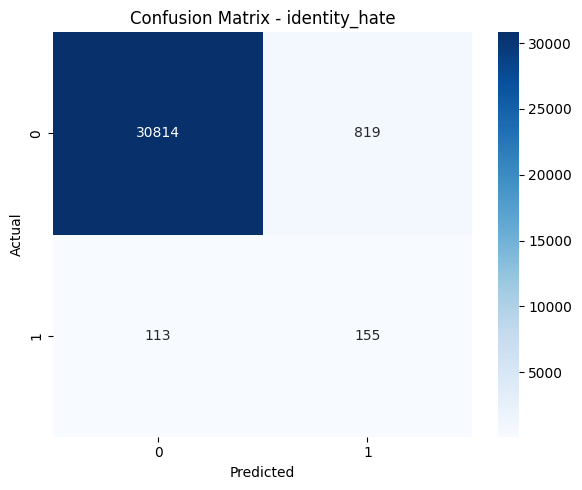

In [ ]:
for i, label in enumerate(toxicity_labels):
    cm = confusion_matrix(y_test[:, i], y_pred_all[:, i])
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {label}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

In [ ]:
sample_comments = [
    "You are absolutely stupid and worthless!",
    "I completely disagree with your political views",
    "This is a wonderful discussion, thank you for sharing",
    "Kill yourself you moron",
    "I think we should consider alternative approaches"
]
processed_comments = [preprocess_text(comment) for comment in sample_comments]
X_sample = vectorizer.transform(processed_comments)

for i, comment in enumerate(sample_comments):
    print(f"\nComment: '{comment}'")
    print("Predictions:")
    for label in toxicity_labels:
        model = models[label]
        prob = model.predict_proba(X_sample[i:i+1])[:, 1][0]
        pred = int(prob >= thresholds[label])
        status = "TOXIC" if pred == 1 else "NOT TOXIC"
        print(f"  {label}: {status} (probability: {prob:.4f})")



Comment: 'You are absolutely stupid and worthless!'
Predictions:
  toxic: TOXIC (probability: 0.9676)
  severe_toxic: TOXIC (probability: 0.9073)
  obscene: TOXIC (probability: 0.9288)
  threat: TOXIC (probability: 0.9087)
  insult: TOXIC (probability: 0.9571)
  identity_hate: NOT TOXIC (probability: 0.4838)

Comment: 'I completely disagree with your political views'
Predictions:
  toxic: NOT TOXIC (probability: 0.2736)
  severe_toxic: NOT TOXIC (probability: 0.0253)
  obscene: NOT TOXIC (probability: 0.0801)
  threat: NOT TOXIC (probability: 0.0007)
  insult: NOT TOXIC (probability: 0.1044)
  identity_hate: NOT TOXIC (probability: 0.0342)

Comment: 'This is a wonderful discussion, thank you for sharing'
Predictions:
  toxic: NOT TOXIC (probability: 0.1868)
  severe_toxic: NOT TOXIC (probability: 0.0047)
  obscene: NOT TOXIC (probability: 0.0916)
  threat: NOT TOXIC (probability: 0.0048)
  insult: NOT TOXIC (probability: 0.1048)
  identity_hate: NOT TOXIC (probability: 0.0557)

Commen

GUI

In [ ]:
import pickle

# Save the vectorizer
with open("vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)

# Save the models
with open("models.pkl", "wb") as f:
    pickle.dump(models, f)

In [ ]:
import gradio as gr
import numpy as np
import pickle
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import pandas as pd
import re

# Toxicity labels used for classification
toxicity_labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Preprocessing function
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    if pd.isna(text):
        return ""
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = ' '.join(text.split())
    words = text.split()
    processed_words = [
        lemmatizer.lemmatize(word)
        for word in words
        if word not in stop_words and len(word) > 2
    ]
    return ' '.join(processed_words)

# Load the vectorizer and models

VECTORIZER_PATH = r"C:\\Users\\sasha\\OneDrive\\Documents\\A Year 4\\ANLP Project\\jigsaw-toxic-comment-classification-challenge\\vectorizer.pkl"
MODELS_PATH = r"C:\\Users\\sasha\\OneDrive\\Documents\\A Year 4\\ANLP Project\\jigsaw-toxic-comment-classification-challenge\\models.pkl"

with open(VECTORIZER_PATH, "rb") as f:
    vectorizer = pickle.load(f)
with open(MODELS_PATH, "rb") as f:
    models = pickle.load(f)

guidelines = """
**Comment Guidelines:**
- Be respectful and considerate.
- No hate speech, threats, or personal attacks.
- Avoid obscene or offensive language.
- Constructive criticism is welcome, but keep it civil.
- Comments violating these rules will be flagged and rewritten.
"""

def is_toxic_with_probs(comment):
    processed = preprocess_text(comment)
    X = vectorizer.transform([processed])
    toxic = False
    toxic_labels = []
    toxic_probs = []
    for label in toxicity_labels:
        prob = models[label].predict_proba(X)[0, 1]
        pred = int(prob >= 0.5)
        if pred == 1:
            toxic = True
            toxic_labels.append(label)
            toxic_probs.append(prob)
    return toxic, toxic_labels, toxic_probs

def detoxify_comment_rule_based(comment, toxic_labels):
    """
    Rule-based approach to convert toxic comments to neutral/positive ones based on detected toxic labels.
    """
    comment_lower = comment.lower()
    detoxified = comment
    # Rules for each label
    label_rules = {
        'toxic': [
            (r'\b(moron|worthless|loser|failure)\b', 'unhelpful'),
            (r'\b(shut up|stfu)\b', 'please be quiet'),
            (r'\b(go away|get lost)\b', 'please leave'),
            (r'\b(annoying|pathetic|lame)\b', 'not helpful'),
            (r'\b(ugly|disgusting)\b', 'unpleasant'),
        ],
        'severe_toxic': [
            (r'\b(destroy|burn in hell)\b', 'stop'),
            (r'i will .*(hurt|harm|kill|murder)', 'I strongly disagree'),
            (r'you should .*(die|disappear|leave)', 'perhaps you could reconsider'),
        ],
        'obscene': [
            (r'\b(hell|damn|crap|bastard|bitch|asshole|fuck|shit|dick|piss|slut|whore)\b', 'unacceptable'),
        ],
        'threat': [
            (r'i will .*(hurt|harm|kill|destroy)', 'I strongly disagree'),
            (r'you should .*(die|disappear|leave)', 'perhaps you could reconsider'),
        ],
        'insult': [
            (r'you are .*(stupid|dumb|idiot)', 'I disagree with your opinion'),
            (r'i hate (you|this|that)', 'I dislike this'),
            (r'this is .*(junk|garbage|trash)', "I don't think this is good"),
        ],
        'identity_hate': [
            (r'\b(\w+\s)?(racist|sexist|homophobic|bigot|nazi|terrorist)\b', 'I respect everyone regardless of identity'),
        ],
    }
    
    # Apply rules for each detected label
    for label in toxic_labels:
        if label in label_rules:
            for pattern, replacement in label_rules[label]:
                detoxified = re.sub(pattern, replacement, detoxified, flags=re.IGNORECASE)
    # If minimal changes were made, provide a generic neutral alternative
    if detoxified.lower() == comment_lower or len(detoxified.strip()) < 3:
        # Generate context-appropriate neutral responses based on toxic labels
        if 'threat' in toxic_labels:
            return "I have concerns about this topic that I'd like to discuss respectfully."
        elif 'insult' in toxic_labels:
            return "I disagree with this perspective and would like to share my thoughts."
        elif 'identity_hate' in toxic_labels:
            return "I have a different viewpoint on this matter."
        elif 'obscene' in toxic_labels:
            return "I feel strongly about this issue and would like to express my opinion appropriately."
        elif 'severe_toxic' in toxic_labels:
            return "Let's keep the conversation respectful and constructive."
        else:
            return "I have feedback I'd like to share in a constructive way."
    return detoxified.strip()


# Then, update your classify_and_rewrite function to use this:
def classify_and_rewrite(comment):
    toxic, labels, probs = is_toxic_with_probs(comment)
    if not toxic:
        return (
            "✅ Comment approved!\n\nYour comment is positive/neutral and follows the guidelines.",
            ""
        )
    else:
        label_info = "\n".join(
            [f"- {label}: {prob*100:.1f}%" for label, prob in zip(labels, probs)]
        )
        new_comment = detoxify_comment_rule_based(comment, labels)
        warning = (
            "⚠️ **Warning:** Your comment was flagged as toxic.\n"
            "Detected toxicity labels and probabilities:\n"
            f"{label_info}\n\n"
            "Please consider the following positive/neutral alternative:\n"
            f"**{new_comment}**"
        )
        return ("", warning)

with gr.Blocks() as demo:
    gr.Markdown(guidelines)
    comment = gr.Textbox(lines=4, label="Enter your comment")
    approve_output = gr.Markdown()
    warning_output = gr.Markdown()
    submit_btn = gr.Button("Submit Comment")
    submit_btn.click(classify_and_rewrite, inputs=comment, outputs=[approve_output, warning_output])

demo.launch()

* Running on local URL:  http://127.0.0.1:7871
* To create a public link, set `share=True` in `launch()`.
